In [4]:
import numpy as np
import skimage as sk
import skimage.io as skio
from skimage.transform import rescale, resize, downscale_local_mean
import os
import scipy
from scipy import signal
from scipy import ndimage
from scipy.ndimage import interpolation
from scipy.ndimage.interpolation import rotate
import cv
import scipy.stats as st
from scipy import ndimage

In [579]:
def save_image(image, saveAs='', display=False):
    # save the image if there's a name to save it as
    if saveAs != None:
        fname = "out_path/" + saveAs + ".jpg"
        skio.imsave(fname, image, cmap='gray')

# Part 1

### Part 1.1

In [597]:
def find_convolution(img, b):
    grad = signal.convolve2d(img, b, mode='same')
    return grad

def basic_convolve(img):
    dx = find_convolution(img, [[1, -1]])
    dy = find_convolution(img, [[1], [-1]])
    convolved_img = np.sqrt(dx**2 + dy**2)
    skio.imshow(convolved_img, cmap='gray')
    skio.show()

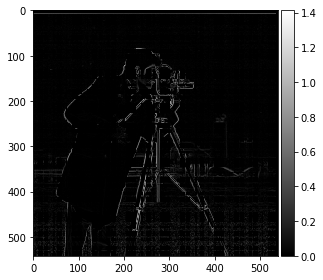

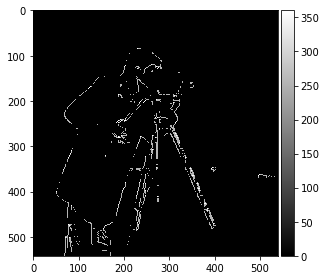

In [618]:
camera_man = skio.imread("data/cameraman.png", 2)
basic_convolve(camera_man)
camera_man_binarized = (camera_man > 0.10)*255
basic_convolve(camera_man_binarized)

### PART 1.2

In [599]:
def get2dGaussianKernel(kernlen, nsig):
    """Returns a 2D Gaussian kernel."""
    x = np.linspace(-nsig, nsig, kernlen)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()

In [610]:
def blur_image_method_one(image_to_convolve, gauss):
    dx = find_convolution(gauss, [[1,-1]])
    dy = find_convolution(gauss, [[1],[-1]])
    convolved_img_dy = find_convolution(image_to_convolve, dy)
    convolved_img_dx = find_convolution(image_to_convolve, dx)
    square_root = np.sqrt(convolved_img_dx**2 + convolved_img_dy**2)
    return square_root

In [611]:
def blur_image_method_two(image_to_convolve, gauss):
    smoothed = find_convolution(image_to_convolve, gauss)
    dx = find_convolution(smoothed, [[1,-1]])
    dy = find_convolution(smoothed, [[1],[-1]])
    square_root = np.sqrt(dx**2 + dy**2)
    return square_root

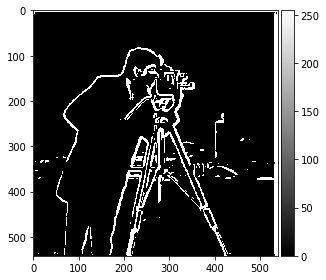

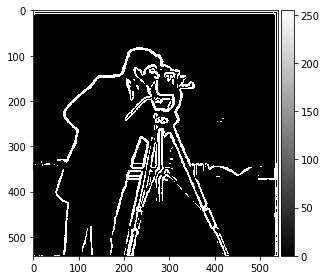

In [612]:
gauss = get2dGaussianKernel(10,2)
original_camera_man = skio.imread("data/cameraman.png", 2)
#Blurs the image to smooth it out
camera_man_meth_one = blur_image_method_one(original_camera_man, gauss)
skio.show()
# Binarizes the edges
camera_man_one_binarized = (camera_man_meth_one > 0.05)*255

camera_man_meth_two = blur_image_method_two(original_camera_man, gauss)
camera_man_two_binarized = (camera_man_meth_two > 0.05)*255
#These images are the same, showing that it doesn't matter which order you perform convolutions in
skio.imshow(np.absolute(camera_man_one_binarized), cmap ="gray")
skio.show()
skio.imshow(np.absolute(camera_man_two_binarized), cmap ="gray")
skio.show()

### PART 1.3

In [501]:
def crop_twenty(image):
    ten_percent_width = int(round(0.2 * image.shape[1]))
    cropped_width = image.shape[1] - 2*ten_percent_width
    
    ten_percent_height = int(round(0.2 * image.shape[0]))
    cropped_height = image.shape[0] - 2*ten_percent_height
    
    cropped = image[ten_percent_height:(ten_percent_height+cropped_height), ten_percent_width:(ten_percent_width+cropped_width)]
    return cropped

In [12]:
def count_axis_degrees(angles):
    right_angles = angles % (math.pi/2.)
    return np.sum(right_angles <= (math.pi/2.) + (math.pi/90)) + np.sum(right_angles >= (math.pi/2.) - (math.pi/90))

In [482]:
def find_best_angle(original):
    potential_angles = np.linspace(-10, 10, 21)
    max_straight_edges = -100
    max_angle = 0

    for angle in potential_angles:
        image_for_rotation = ndimage.rotate(original, angle, reshape=False)
        cropped_rotated = crop_twenty(image_for_rotation)

        smooth_img = find_convolution(cropped_rotated, gauss)
        convolved_img_dy = find_convolution(smooth_img, [[1],[-1]])
        convolved_img_dx = find_convolution(smooth_img, [[1,-1]])

        num_straight_edges = np.arctan2(convolved_img_dy,convolved_img_dx)
        num_straight_1d = num_straight_edges.flatten()

        num_straight_edges = count_axis_degrees(num_straight_1d)

        if(num_straight_edges > max_straight_edges):
            max_straight_edges = num_straight_edges
            edges_arr = num_straight_1d
            max_angle = angle

    best_rotated_image = scipy.ndimage.interpolation.rotate(original,max_angle)
    return (best_rotated_image, max_straight_edges, edges_arr, max_angle)

In [483]:
def rotate_and_display(original):
    print("BEFORE: ")
    skio.imshow(np.absolute(original), cmap ="gray")
    skio.show()

    cropped_rotated = crop_twenty(original)

    smooth_img = find_convolution(cropped_rotated, gauss)
    convolved_img_dy = find_convolution(smooth_img, [[1],[-1]])
    convolved_img_dx = find_convolution(smooth_img, [[1,-1]])

    num_straight_edges = np.arctan2(convolved_img_dy,convolved_img_dx)
    num_straight_1d = num_straight_edges.flatten()

    plt.hist(num_straight_1d, bins=50)
    plt.show()

    print("AFTER: ")
    (best_rotated_image, max_straight_edges, edges_arr, max_angle) = find_best_angle(original)

    print("The best rotated angle is: " + str(max_angle))
    
    cropped = crop_twenty(best_rotated_image)
    skio.imshow(np.absolute(cropped), cmap ="gray")
    skio.show()
    
    plt.hist(edges_arr, bins=50)
    plt.show()

BEFORE: 


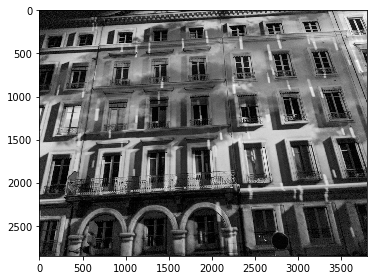

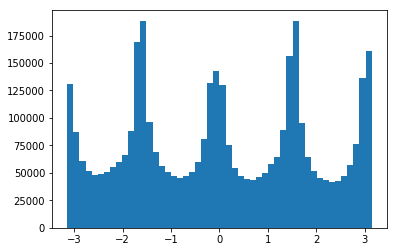

AFTER: 
The best rotated angle is: -2.0


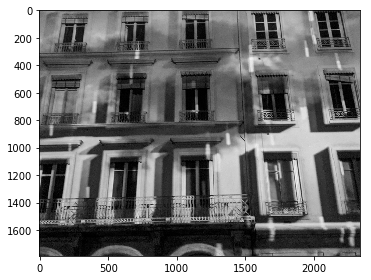

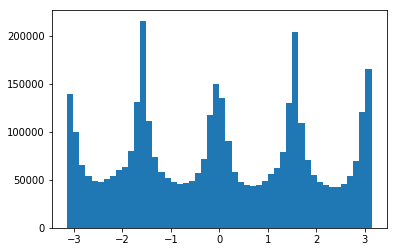

In [479]:
# Class example
original = skio.imread("data/facade.jpg", 2) 
rotate_and_display(original)

BEFORE: 


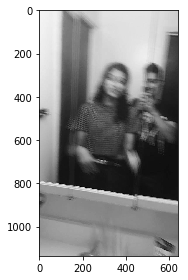

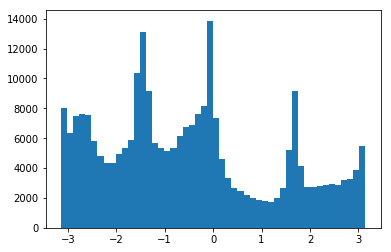

AFTER: 
The best rotated angle is: 10.0


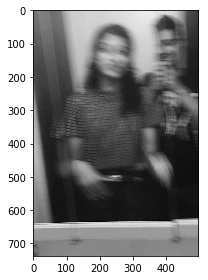

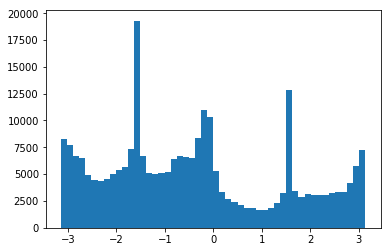

In [484]:
mirror = skio.imread("data/mirror.jpg", 2) 
rotate_and_display(mirror)

BEFORE: 


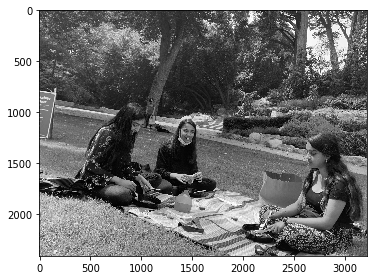

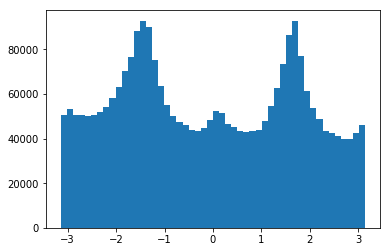

AFTER: 
The best rotated angle is: 10.0


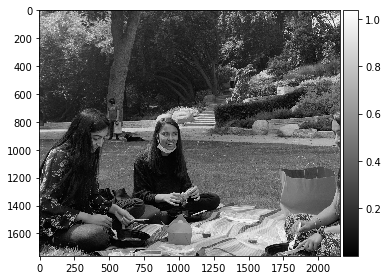

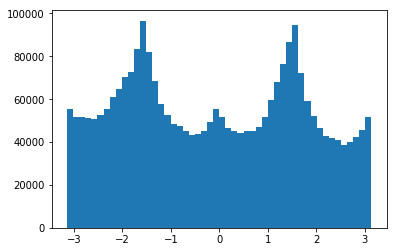

In [485]:
picnic = skio.imread("data/picnic.jpg", 2) 
rotate_and_display(picnic)

BEFORE: 


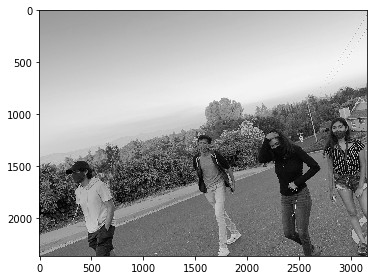

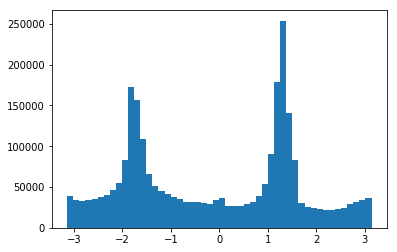

AFTER: 
The best rotated angle is: -10.0


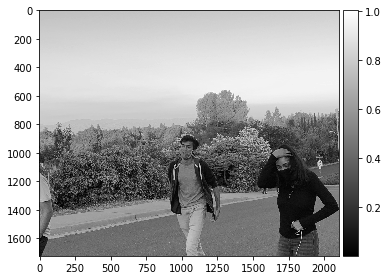

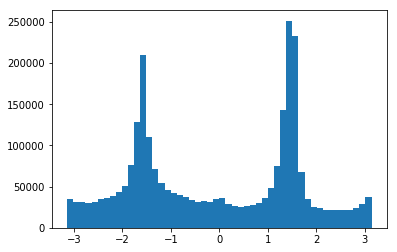

In [486]:
walk = skio.imread("data/walk.jpg", 2) 
rotate_and_display(walk)

BEFORE: 


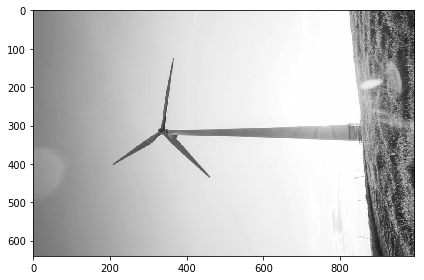

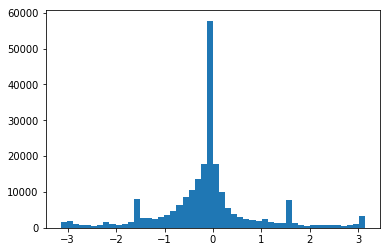

AFTER: 
The best rotated angle is: 1.0


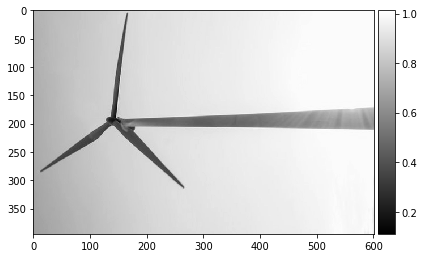

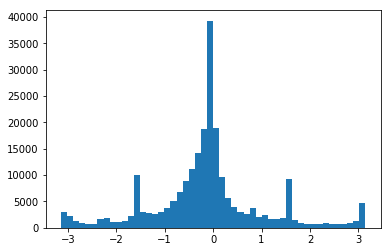

In [620]:
windmill = skio.imread("data/windmill.jpg", 2) 
rotate_and_display(windmill)

# Part 2


### Part 2.1

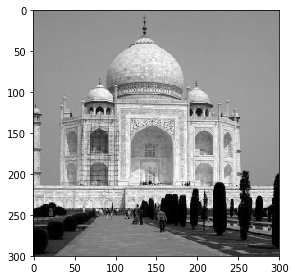

In [16]:
taj = skio.imread("data/taj.jpg", 2)
skio.imshow(taj)
skio.show()

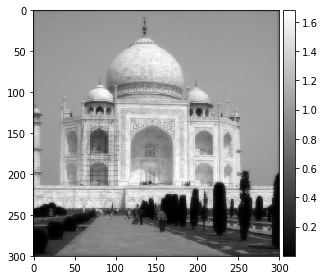

In [87]:
gauss = get2dGaussianKernel(10,2)
taj_blurred = 0.75*find_convolution(taj, gauss) + taj
skio.imshow(np.absolute(taj_blurred), cmap ="gray")
skio.show()

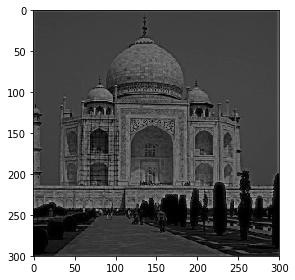

In [88]:
taj_details = taj - taj_blurred
taj_sharped = taj + 0.75*taj_details
skio.imshow(np.absolute(taj_sharped), cmap ="gray")
skio.show()

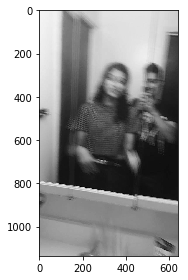

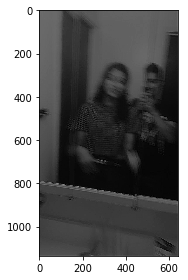

In [592]:
# Sharpening a blurry image:
mirror = skio.imread("data/mirror.jpg", 2)
skio.imshow(mirror)
skio.show()

gauss = get2dGaussianKernel(10,2)
mirror_blurred = 0.75*find_convolution(mirror, gauss) + mirror

mirror_details = mirror - mirror_blurred
mirror_sharped = mirror + 0.75*mirror_details
skio.imshow(np.absolute(mirror_sharped), cmap ="gray")
skio.show()

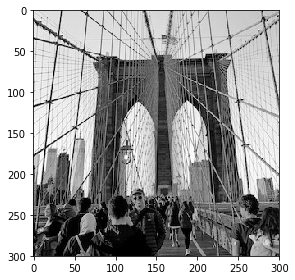

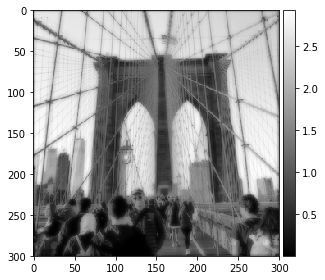

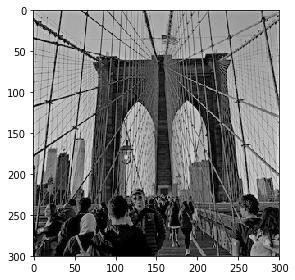

In [589]:
# Blur an image using gaussian blur, and then sharpen it
bbridge = skio.imread("data/bbridge.jpg", 2)
skio.imshow(bbridge)
skio.show()

gauss = get2dGaussianKernel(10,2)

bbridge = 0.75*find_convolution(bbridge, gauss) + bbridge

bbridge_blurred = 0.75*find_convolution(bbridge, gauss) + bbridge

skio.imshow(np.absolute(bbridge_blurred), cmap ="gray")
skio.show()

bbridge_details = bbridge - bbridge_blurred
bbridge_sharped = bbridge + 0.75*bbridge_details
skio.imshow(np.absolute(bbridge_sharped), cmap ="gray")
skio.show()

### Part 2.2

In [487]:
import math
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform as sktr

def get_points(im1, im2):
    print('Please select 2 points in each image for alignment.')
    plt.imshow(im1)
    p1, p2 = plt.ginput(2)
    plt.close()
    plt.imshow(im2)
    p3, p4 = plt.ginput(2)
    plt.close()
    return (p1, p2, p3, p4)

def recenter(im, r, c):
    R, C, _ = im.shape
    rpad = (int) (np.abs(2*r+1 - R))
    cpad = (int) (np.abs(2*c+1 - C))
    return np.pad(
        im, [(0 if r > (R-1)/2 else rpad, 0 if r < (R-1)/2 else rpad),
             (0 if c > (C-1)/2 else cpad, 0 if c < (C-1)/2 else cpad),
             (0, 0)], 'constant')

def find_centers(p1, p2):
    cx = np.round(np.mean([p1[0], p2[0]]))
    cy = np.round(np.mean([p1[1], p2[1]]))
    return cx, cy

def align_image_centers(im1, im2, pts):
    p1, p2, p3, p4 = pts
    h1, w1, b1 = im1.shape
    h2, w2, b2 = im2.shape
    
    cx1, cy1 = find_centers(p1, p2)
    cx2, cy2 = find_centers(p3, p4)

    im1 = recenter(im1, cy1, cx1)
    im2 = recenter(im2, cy2, cx2)
    return im1, im2

def rescale_images(im1, im2, pts):
    p1, p2, p3, p4 = pts
    len1 = np.sqrt((p2[1] - p1[1])**2 + (p2[0] - p1[0])**2)
    len2 = np.sqrt((p4[1] - p3[1])**2 + (p4[0] - p3[0])**2)
    dscale = len2/len1
    if dscale < 1:
        im1 = sktr.rescale(im1, dscale)
    else:
        im2 = sktr.rescale(im2, 1./dscale)
    return im1, im2

def rotate_im1(im1, im2, pts):
    p1, p2, p3, p4 = pts
    theta1 = math.atan2(-(p2[1] - p1[1]), (p2[0] - p1[0]))
    theta2 = math.atan2(-(p4[1] - p3[1]), (p4[0] - p3[0]))
    dtheta = theta2 - theta1
    im1 = sktr.rotate(im1, dtheta*180/np.pi)
    return im1, dtheta

def match_img_size(im1, im2):
    # Make images the same size
    h1, w1, c1 = im1.shape
    h2, w2, c2 = im2.shape
    if h1 < h2:
        im2 = im2[int(np.floor((h2-h1)/2.)) : -int(np.ceil((h2-h1)/2.)), :, :]
    elif h1 > h2:
        im1 = im1[int(np.floor((h1-h2)/2.)) : -int(np.ceil((h1-h2)/2.)), :, :]
    if w1 < w2:
        im2 = im2[:, int(np.floor((w2-w1)/2.)) : -int(np.ceil((w2-w1)/2.)), :]
    elif w1 > w2:
        im1 = im1[:, int(np.floor((w1-w2)/2.)) : -int(np.ceil((w1-w2)/2.)), :]
    assert im1.shape == im2.shape
    return im1, im2

def align_images(im1, im2):
    pts = get_points(im1, im2)
    im1, im2 = align_image_centers(im1, im2, pts)
    im1, im2 = rescale_images(im1, im2, pts)
    im1, angle = rotate_im1(im1, im2, pts)
    im1, im2 = match_img_size(im1, im2)
    return im1, im2

In [614]:
# high sf
derek = skio.imread('data/DerekPicture.jpg', 2)
# low sf
cat = skio.imread('data/nutmeg.jpg', 2)
#derek_aligned, cat_aligned = align_images(derek,cat)

derek_aligned = skio.imread('data/derek_aligned.jpeg', 2)
cat_aligned = skio.imread('data/nutmeg_aligned.jpeg', 2)

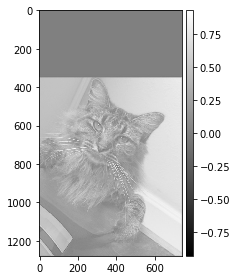

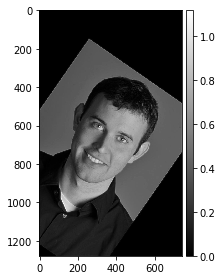

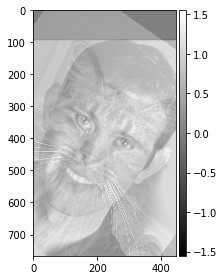

In [573]:
sigma1 = 2
sigma2 = 2
im2_sharp,im1_blurred = hybrid_image(derek_aligned, cat_aligned, sigma1, sigma2)
hybrid_cat_derek = im2_sharp + im1_blurred
skio.imshow(im2_sharp, cmap="gray")
skio.show()
skio.imshow(im1_blurred, cmap="gray")
skio.show()
skio.imshow(crop_twenty(hybrid_cat_derek), cmap="gray")
skio.show()

In [574]:
def hybrid_image(im1, im2, sigma1, sigma2):
    gauss1 = get2dGaussianKernel(10,sigma1)
    gauss2 = get2dGaussianKernel(10,sigma2)
    im1_blurred = 1.5*blur_image_method_two(im1, gauss1) + im1
    im2_blurred = 1.5*blur_image_method_two(im2, gauss2) + im2
    im2_details = im2 - im2_blurred
    im2_sharp = im2 + 1.5*im2_details
    return (im2_sharp,im1_blurred)

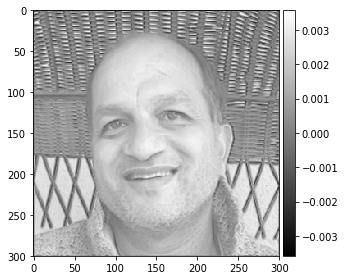

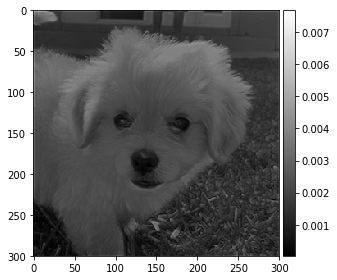

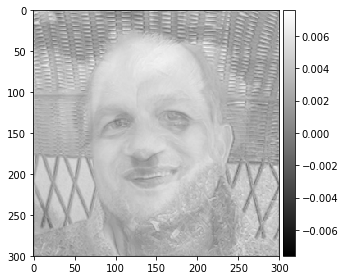

In [615]:
sigma2 = 5
# low sf
kumar = skio.imread('data/kumar.jpg', 2)/255

sigma1 = 5
# high sf
rio2 = skio.imread('data/rio2.jpg', 2)/255

im2_sharp,im1_blurred = hybrid_image(rio2, kumar, sigma1, sigma2)
hybrid_dog_dad = im2_sharp + im1_blurred

skio.imshow(im2_sharp, cmap="gray")
skio.show()
skio.imshow(im1_blurred, cmap="gray")
skio.show()
skio.imshow(hybrid_dog_dad, cmap="gray")
skio.show()

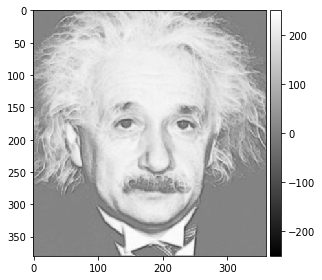

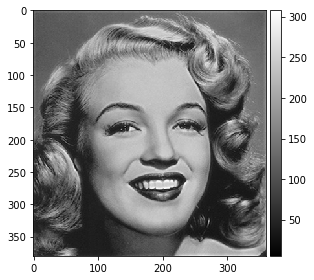

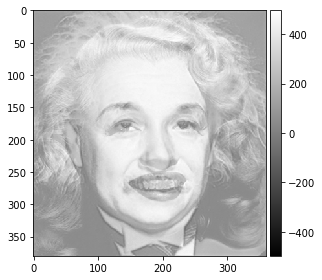

In [582]:
# high sf
sigma2 = 4

monroe = skio.imread('data/monroe.jpeg', 2)

# low sf
sigma1 = 2
einstein = skio.imread('data/einstein.jpeg', 2)

im2_sharp,im1_blurred = hybrid_image(monroe, einstein, sigma1, sigma2)
hybrid_ein_mon = im2_sharp + im1_blurred

skio.imshow(im2_sharp, cmap="gray")
skio.show()
skio.imshow(im1_blurred, cmap="gray")
skio.show()
skio.imshow(hybrid_ein_mon, cmap="gray")
skio.show()

Monroe: 


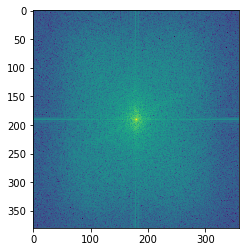

In [616]:
print("Monroe: ")
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(monroe)))))

Einstein: 


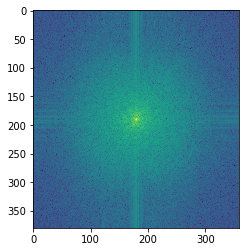

In [559]:
print("Einstein: ")
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(einstein)))))

High pass monroe: 


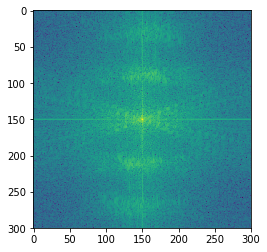

In [560]:
print("High pass monroe: ")
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(im2_sharp)))))

Low pass Einstein: 


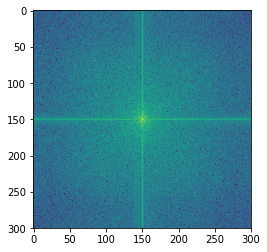

In [561]:
print("Low pass Einstein: ")
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(im1_blurred)))))

Hybrid: 


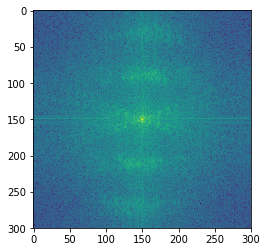

In [562]:
print("Hybrid: ")
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(hybrid)))))

### Part 2.3

In [585]:
def create_gaussian_stack(image, gauss):
    stack = []
    stack.append(image)
    for x in range(0, 6):
        image = find_convolution(image, gauss)
        stack.append(image)
    return stack

In [586]:
def get_laplacian_stack(gaussian_stack):
    laplacian_stack = []
    for x in range(0,len(gaussian_stack) - 1):
        laplacian_stack.append(gaussian_stack[x] - gaussian_stack[x+1])
    return laplacian_stack

GAUSSIAN STACK OF LINCLON: 


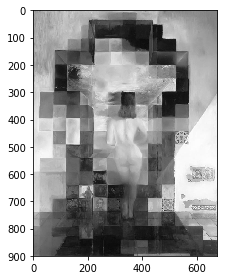

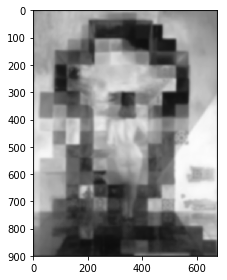

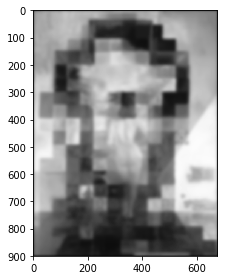

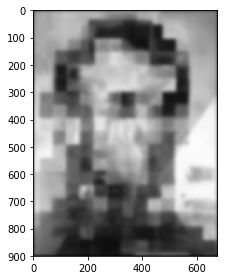

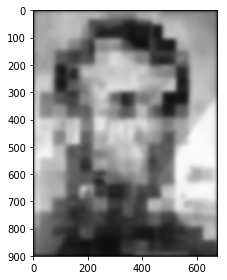

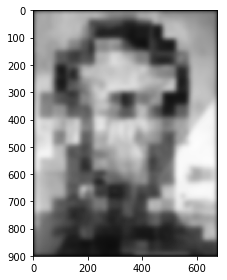

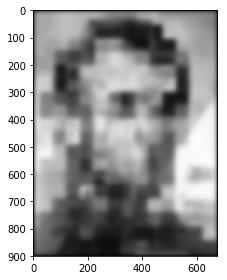

LAPLACIAN STACK OF LINCLON: 


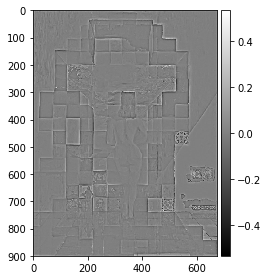

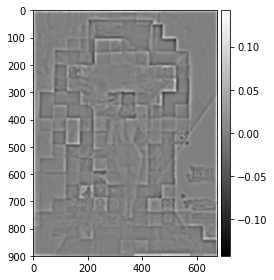

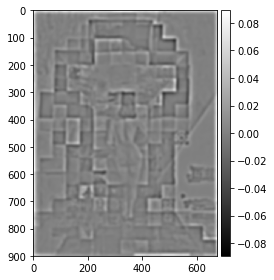

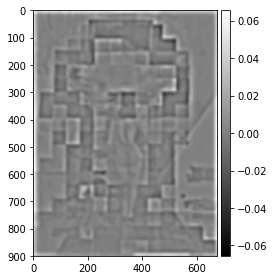

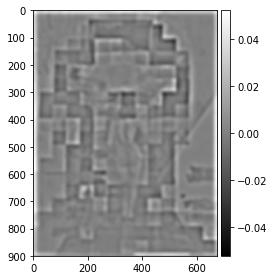

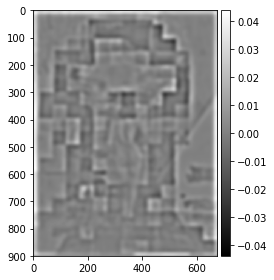

COMBINED: 


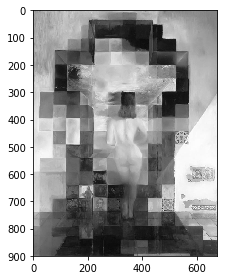

In [588]:
lincolngala = skio.imread('data/lincolngala.jpg', 2)
gauss = get2dGaussianKernel(40,5)
gaussian_stack = create_gaussian_stack(lincolngala, gauss)

print("GAUSSIAN STACK OF LINCLON: ")
for gauss_img in gaussian_stack:
    skio.imshow(gauss_img, cmap="gray")
    skio.show()
    
laplacian_stack = get_laplacian_stack(gaussian_stack)

print("LAPLACIAN STACK OF LINCLON: ")
for lap_img in laplacian_stack:
    skio.imshow(lap_img, cmap="gray")
    skio.show()

combined = laplacian_stack[0] + gaussian_stack[6]
for x in range(1, 6):
    combined += laplacian_stack[x]
    
print("COMBINED: ")
skio.imshow(combined, cmap="gray")
skio.show()

GAUSSIAN STACK OF EIN/MONROE: 


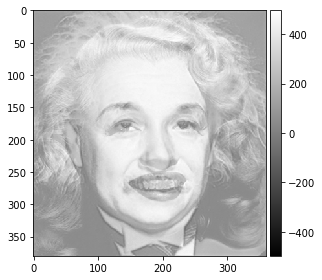

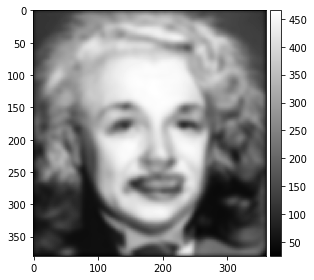

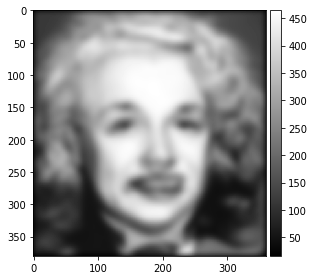

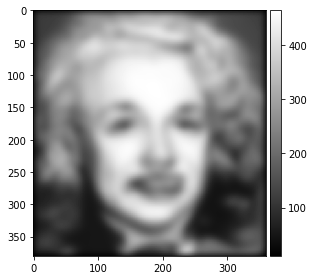

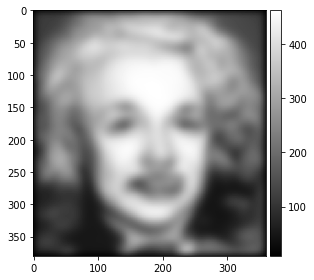

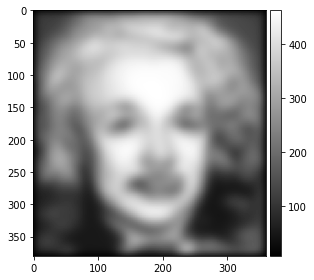

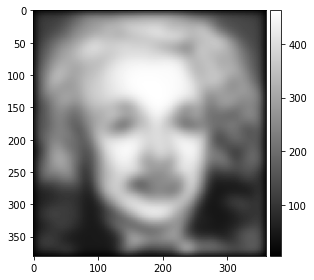

LAPLACIAN STACK OF EIN/MONROE: 


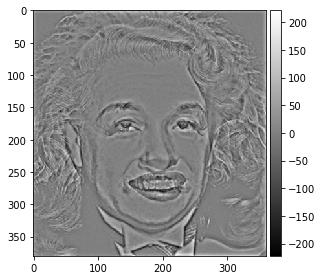

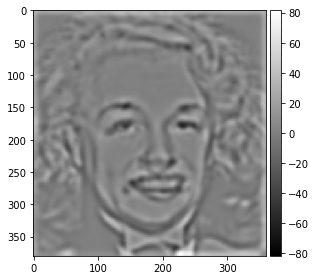

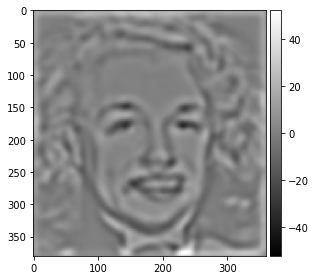

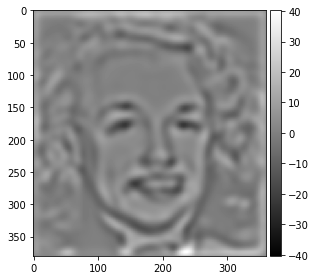

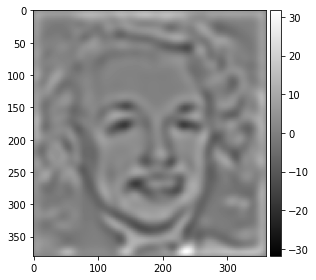

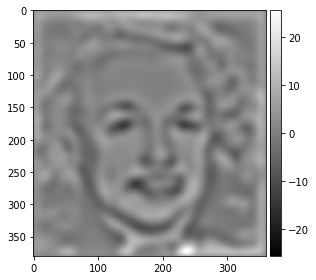

Combined: 


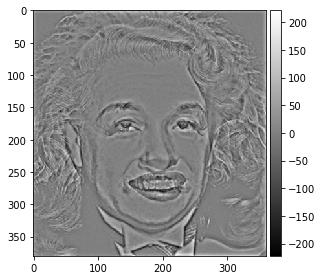

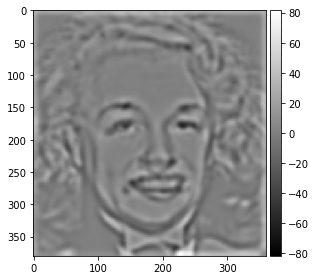

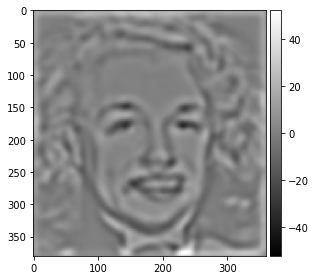

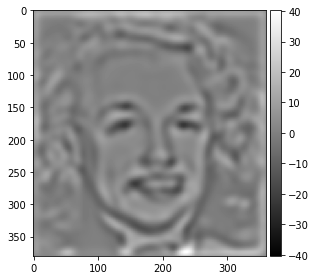

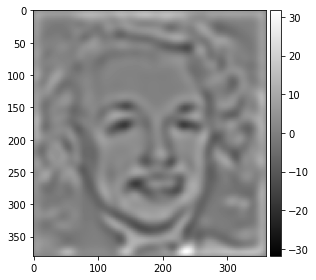

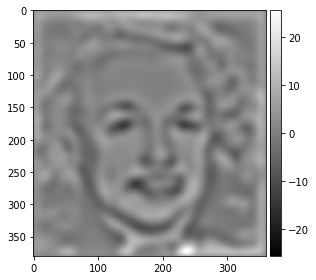

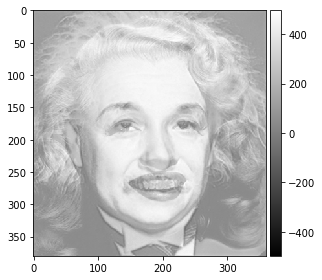

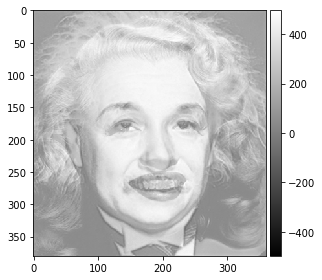

In [593]:
gauss = get2dGaussianKernel(40,5)
gaussian_stack = create_gaussian_stack(hybrid_ein_mon, gauss)

print("GAUSSIAN STACK OF EIN/MONROE: ")
for gauss_img in gaussian_stack:
    skio.imshow(gauss_img, cmap="gray")
    skio.show()

laplacian_stack = get_laplacian_stack(gaussian_stack)

print("LAPLACIAN STACK OF EIN/MONROE: ")
for lap_img in laplacian_stack:
    skio.imshow(lap_img, cmap="gray")
    skio.show()

print("Combined: ")
combined = laplacian_stack[0] + gaussian_stack[6]
for x in range(1, 6):
    combined += laplacian_stack[x]

for img in laplacian_stack:
    skio.imshow(img, cmap="gray")
    skio.show()
skio.imshow(combined, cmap="gray")
skio.show()
skio.imshow(hybrid_ein_mon, cmap="gray")
skio.show()

### Part 2.4

In [371]:
#Build Laplacian pyramids LA and LB for images A and B respectively.
#Build a Gaussian pyramid GM for the mask M
#Form a combined pyramid LS from LA and LB using nodes of GM as weights. That is, for each level: LS(level) = LA(level)GM(level) + LB(level)*(1-GM(level))
#Obtain the splined image S by summing the levels of LS

In [375]:
# helper functions
def get_vertical_mask(height, width, divider=0.5, display=False):
    divide_line = (np.linspace(0, 1, width) < divider)*1
    mask = np.tile(divide_line, (height, 1))
    # mask_3d = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    return mask

def get_gradient_mask(height, width, divider=0.5, display=False):
    divide_line = np.linspace(1, 0, width)
    mask = np.tile(divide_line, (height, 1))
    # mask_3d = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    return mask

def get_circular_mask(h, w, center=None, radius=None):
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= radius
    return mask

In [435]:
def multi_res_blending_with_vert(img1,img2):
    gauss = get2dGaussianKernel(40,3)
    ga = create_gaussian_stack(img1, gauss)
    go = create_gaussian_stack(img2, gauss)

    la = get_laplacian_stack(ga)
    lo = get_laplacian_stack(go)

    mask = get_vertical_mask(300,300, display=True)
    gm = create_gaussian_stack(mask, gauss)

    ls = []
    for x in range(0, 6):
        ls.append(la[x]*gm[x] + lo[x]*(1-gm[x]))
    splined_img = sum(ls)
    skio.imshow(splined_img, cmap="gray")
    skio.show()
    
def multi_res_blending_with_circ(img1,img2, center, radius):
    gauss = get2dGaussianKernel(40,3)
    ga = create_gaussian_stack(img1, gauss)
    go = create_gaussian_stack(img2, gauss)

    la = get_laplacian_stack(ga)
    lo = get_laplacian_stack(go)

    mask = get_circular_mask(300,300, center,radius)
    gm = create_gaussian_stack(mask, gauss)

    ls = []
    for x in range(0, 6):
        ls.append(la[x]*gm[x] + lo[x]*(1-gm[x]))
    splined_img = sum(ls)
    skio.imshow(splined_img, cmap="gray")
    skio.show()
    
def multi_res_blending_with_grad(img1,img2):
    gauss = get2dGaussianKernel(40,3)
    ga = create_gaussian_stack(img1, gauss)
    go = create_gaussian_stack(img2, gauss)

    la = get_laplacian_stack(ga)
    lo = get_laplacian_stack(go)

    mask = get_gradient_mask(300,300, display=True)
    gm = create_gaussian_stack(mask, gauss)

    ls = []
    for x in range(0, 6):
        ls.append(la[x]*gm[x] + lo[x]*(1-gm[x]))
    splined_img = sum(ls)
    skio.imshow(splined_img, cmap="gray")
    skio.show()

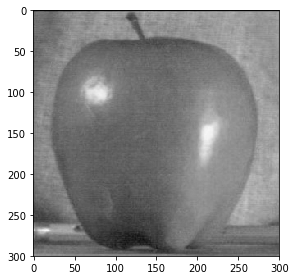

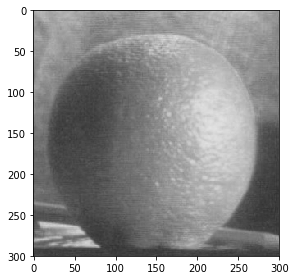

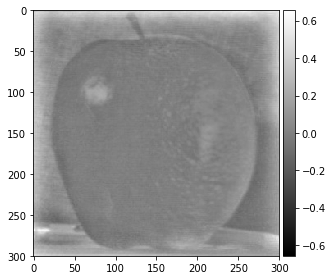

In [427]:
apple = skio.imread('data/apple.jpeg', 2)
orange = skio.imread('data/orange.jpeg', 2)
skio.imshow(apple, cmap="gray")
skio.show()
skio.imshow(orange, cmap="gray")
skio.show()
multi_res_blending_with_grad(apple,orange)

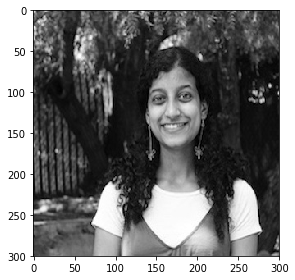

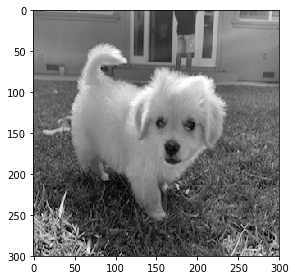

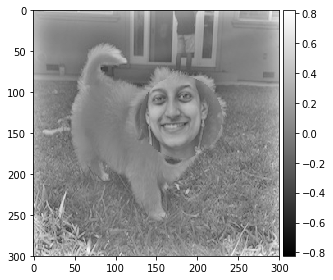

In [419]:
chetana = skio.imread('data/chetana.jpg', 2)
rio = skio.imread('data/rio.jpg', 2)
skio.imshow(chetana, cmap="gray")
skio.show()
skio.imshow(rio, cmap="gray")
skio.show()
multi_res_blending_with_circ(chetana,rio, center= (180,130), radius = 50)

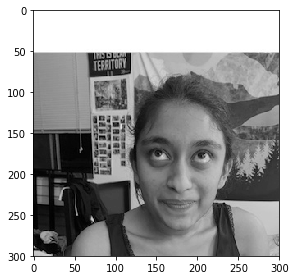

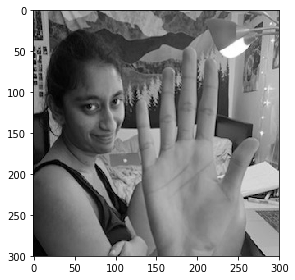

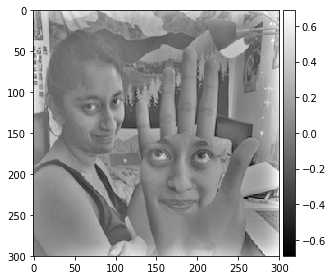

In [462]:
eyes = skio.imread('data/avnieyes.jpg', 2) 
hands = skio.imread('data/hand.jpg', 2)
skio.imshow(eyes, cmap="gray")
skio.show()
skio.imshow(hands, cmap="gray")
skio.show()
multi_res_blending_with_circ(eyes,hands, center=(180,200), radius=50)

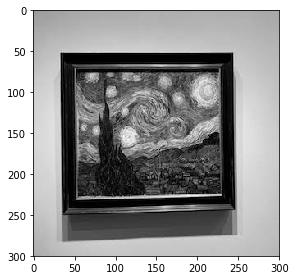

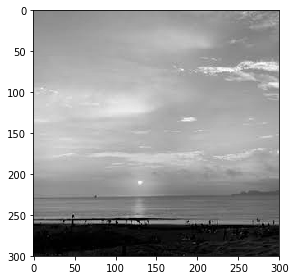

Laplacian Stack for beach: 


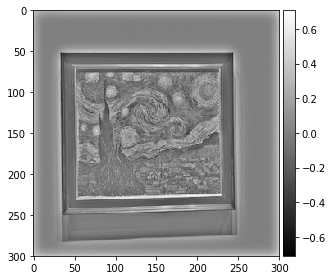

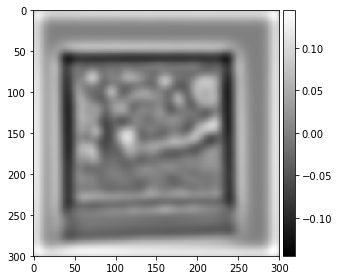

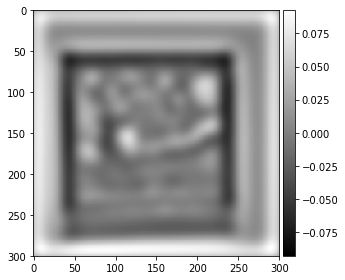

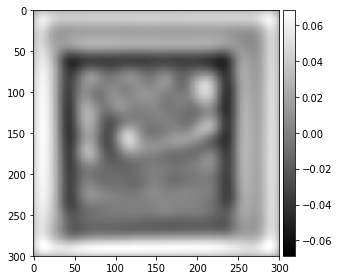

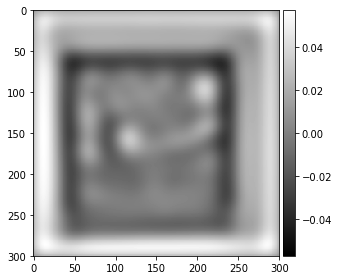

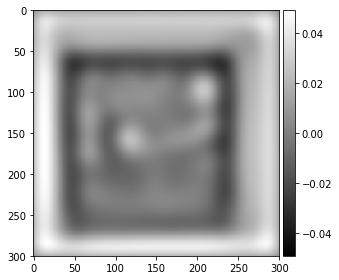

Laplacian Stack for painting: 


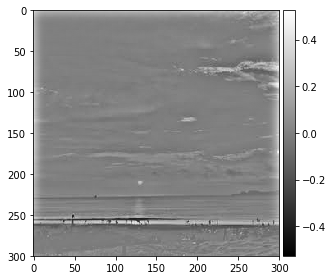

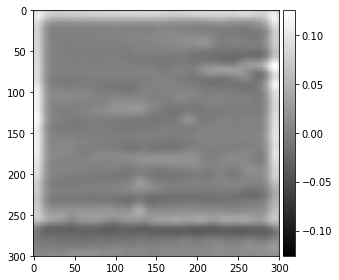

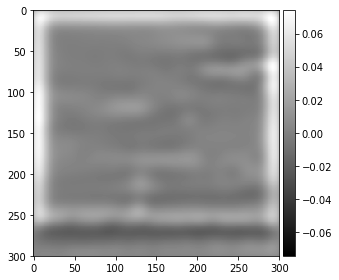

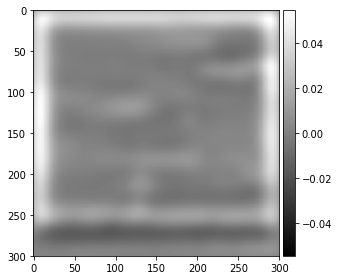

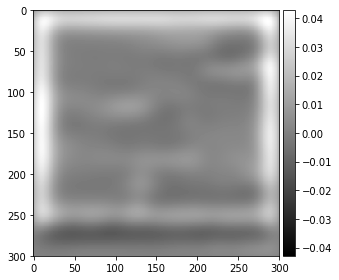

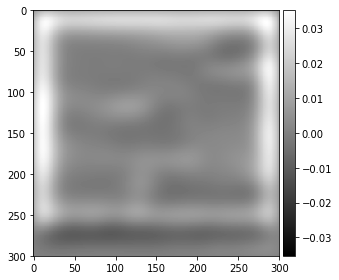

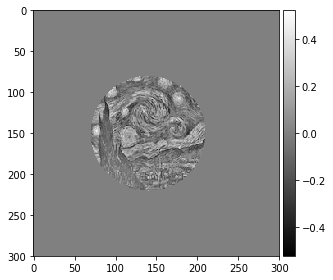

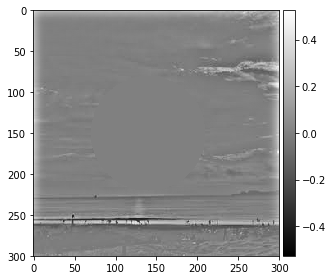

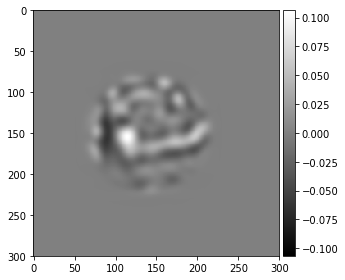

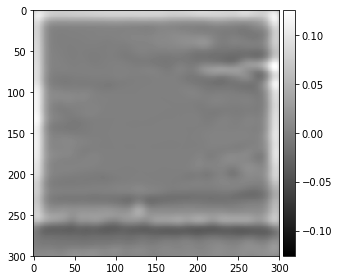

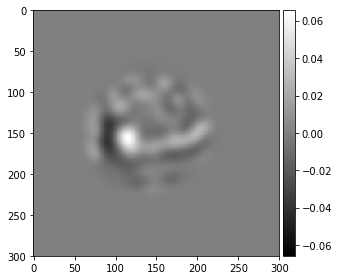

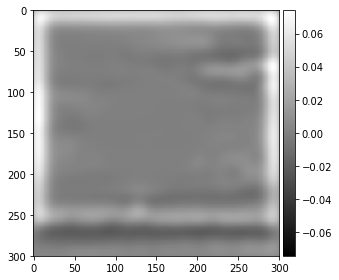

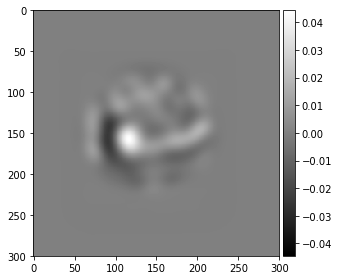

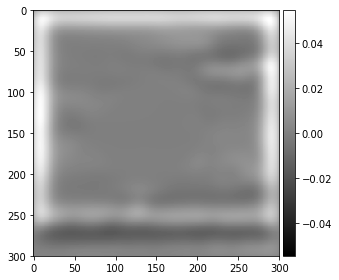

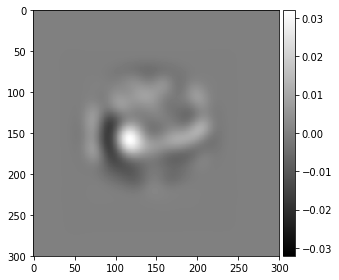

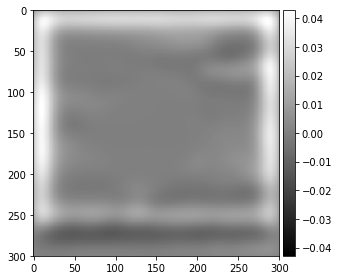

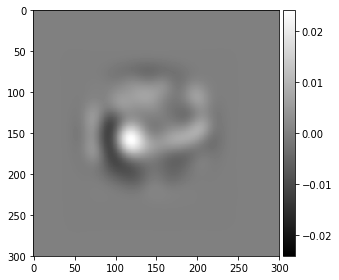

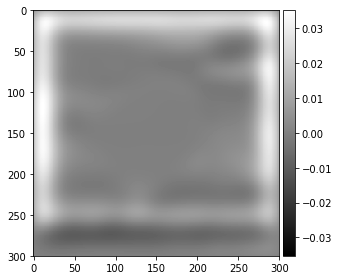

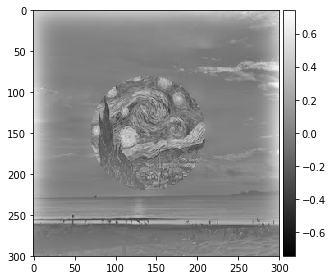

In [468]:
img1 = skio.imread('data/paint.jpg', 2) 
img2 = skio.imread('data/bakerbeach.jpg', 2)
skio.imshow(img1, cmap="gray")
skio.show()
skio.imshow(img2, cmap="gray")
skio.show()

gauss = get2dGaussianKernel(40,3)
ga = create_gaussian_stack(img1, gauss)
go = create_gaussian_stack(img2, gauss)

la = get_laplacian_stack(ga)

print("Laplacian Stack for beach: ")
for img in la:
    skio.imshow(img, cmap="gray")
    skio.show()
    
lo = get_laplacian_stack(go)
print("Laplacian Stack for painting: ")
for img in lo:
    skio.imshow(img, cmap="gray")
    skio.show()

mask = get_circular_mask(300,300, center=(140,150), radius=70)
gm = create_gaussian_stack(mask, gauss)

ls = []
for x in range(0, 6):
    skio.imshow(la[x]*gm[x], cmap="gray")
    skio.show()
    skio.imshow(lo[x]*(1-gm[x]), cmap="gray")
    skio.show()
    ls.append(la[x]*gm[x] + lo[x]*(1-gm[x]))

splined_img = sum(ls)
skio.imshow(splined_img, cmap="gray")
skio.show()

In [415]:
# CODE FOR attempting LAPLACIAN COLOR    
#         curr_r = curr[:,:,0]
#         curr_g = curr[:,:,1]
#         curr_b = curr[:,:,2]
#         skio.imshow(curr_r, cmap="gray")
#         skio.show()
#         next_r = next_img[:,:,0]
#         next_g = next_img[:,:,1]
#         next_b = next_img[:,:,2]
        
#         skio.imshow(next_r, cmap="gray")
#         skio.show()
        
#         r_l = (curr_r - next_r)
#         g_l = (curr_g - next_g)
#         b_l = (curr_b - next_b)
#         print("rl")
#         skio.imshow(r_l, cmap="gray")
#         skio.show()
        
#         print(min(r_l.flatten()))
#         print(max(r_l.flatten()))
#         print(min(g_l.flatten()))
#         print(max(g_l.flatten()))
#         print(min(b_l.flatten()))
#         print(max(b_l.flatten()))
        
#         image = np.dstack([r_l, g_l, b_l])
#         skio.imshow(image, cmap="gray")
#         skio.show()